In [9]:
import pandas as pd
import ast
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from group_recommender_algs import group_rec, get_wine_with_top_categories
import importlib
import group_recommender_algs  # Dein Modul, in dem die Funktion gespeichert ist

# Neu laden des Moduls, um die Änderungen zu übernehmen
importlib.reload(group_recommender_algs)


# Load the datasets (replace 'ratings.csv' and 'wine_characteristics.csv' with the actual CSV file paths)
ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')
wine_data = pd.read_csv('Dataset/last/XWines_Slim_1K_wines.csv')
group_data = pd.read_csv('Dataset/last/group_composition.csv')  # Add path to your group CSV

# Merge the two datasets on 'WineID'
merged_data = pd.merge(ratings_data, wine_data, on='WineID')

C:\Users\antoi\AppData\Local\Temp\ipykernel_11612\1387989594.py:14: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')


In [10]:
ratings = {}
for index, row in ratings_data.iterrows():
    if row['WineID'] not in ratings:
        ratings[row['WineID']] = {"total": row['Rating'], "count": 1}
    else:
        ratings[row['WineID']]["total"] += row['Rating']
        ratings[row['WineID']]["count"] += 1

# add the averages to the df
wine_data["AvgRating"] = 0.0

for index, row in wine_data.iterrows():
    wine_data.loc[index, "AvgRating"] = ratings[row["WineID"]]["total"]/ratings[row["WineID"]]["count"]

In [11]:
def get_wines_rated_by_group(group_df, group_id, ratings_df, wine_id=None):
    # Step 1: Extract group members based on `group_id`
    group_row = group_df[group_df['group_id'] == group_id]

    # Step 2: Check if the group ID exists
    if group_row.empty:
        print(f"Group with ID {group_id} not found.")
        return pd.DataFrame(columns=['UserID', 'WineID', 'Rating'])

    # Step 3: Convert the `group_members` string to a list
    group_members_str = group_row['group_members'].values[0]
    group_members = ast.literal_eval(group_members_str)  # Safely convert string to list

    # Step 4: Filter `ratings_df` for UserIDs in the `group_members` list
    filtered_ratings = ratings_df[ratings_df['UserID'].isin(group_members)]

    # Step 5: If `wine_id` is provided, filter further
    if wine_id is not None:
        # Use `isin` if `wine_id` is a list
        if isinstance(wine_id, list):
            filtered_ratings = filtered_ratings[filtered_ratings['WineID'].isin(wine_id)]
        else:
            # Otherwise, filter for a single WineID
            filtered_ratings = filtered_ratings[filtered_ratings['WineID'] == wine_id]

    # Step 6: Return the filtered DataFrame
    return filtered_ratings[['UserID', 'WineID', 'Rating']]


In [25]:
from group_recommender_algs import group_rec

In [20]:
import pandas as pd
from tqdm import tqdm
import plotly.express as px

# Assuming `group_data`, `ratings_data`, `merged_data`, and `wine_data` are already defined DataFrames.

# Schritt 1: Leere Listen erstellen, um die durchschnittlichen Bewertungen und die individuellen Bewertungen zu speichern
group_avg_ratings = []  # Liste für durchschnittliche Bewertungen pro Gruppe
individual_ratings = []  # Liste für individuelle Bewertungen jedes Gruppenmitglieds

# Schritt 2: Iteration über alle Gruppen-IDs (0 bis 239) mit Fortschrittsanzeige
for group_id in tqdm(range(240), desc="Processing Group IDs", unit="group"):
    try:
        # Schritt 3: Get the top 5 wine recommendations for the current group using the `group_rec` function
        recommended_wines = group_rec(group_id, group_data, merged_data, wine_data, ratings_data)

        # Überprüfen, ob Empfehlungen zurückgegeben wurden
        if recommended_wines is None or recommended_wines.empty:
            print(f"Keine Empfehlungen für Gruppe {group_id}. Überspringen...")
            group_avg_ratings.append((group_id, None))
            continue


        # Konvertieren Sie die WineIDs in eine Liste
        if 'WineID' in recommended_wines.columns:
            wine_id_list = recommended_wines['WineID'].tolist()
        else:
            print(f"Keine gültige 'WineID'-Spalte für Gruppe {group_id}. Überspringen...")
            group_avg_ratings.append((group_id, None))
            continue

        # Schritt 4: Holen Sie die Bewertungen der Gruppenmitglieder für die empfohlenen Weine
        group_ratings_df = get_wines_rated_by_group(
            group_df=group_data,
            group_id=group_id,
            ratings_df=ratings_data,
            wine_id=wine_id_list
        )

        # Schritt 5: Durchschnittliche Bewertung für die zurückgegebenen Weine berechnen
        if not group_ratings_df.empty:
            avg_rating = group_ratings_df['Rating'].mean()
        else:
            avg_rating = None  # Keine Bewertungen gefunden

        # Speichern der individuellen Bewertungen in `individual_ratings`
        for _, row in group_ratings_df.iterrows():
            individual_ratings.append({
                'GroupID': group_id,
                'UserID': row['UserID'],
                'WineID': row['WineID'],
                'Rating': row['Rating']
            })

    except ValueError as e:
        # Fehler abfangen und None als Durchschnittswert speichern
        print(f"Fehler bei Gruppe {group_id}: {e}")
        avg_rating = None

    # Schritt 6: Ergebnis als Tupel (GroupID, AverageRating) speichern
    group_avg_ratings.append((group_id, avg_rating))

# Schritt 7: Ausgabe der durchschnittlichen Bewertungen für jede Gruppe als DataFrame
group_avg_ratings_df = pd.DataFrame(group_avg_ratings, columns=["GroupID", "AverageRating"])

# Schritt 8: Ausgabe der individuellen Bewertungen als DataFrame
individual_ratings_df = pd.DataFrame(individual_ratings, columns=["GroupID", "UserID", "WineID", "Rating"])

# Debug-Ausgabe: Anzeigen der Struktur und der ersten Zeilen von `group_avg_ratings_df`
print("Erste 5 Zeilen von group_avg_ratings_df:")
print(group_avg_ratings_df.head())

print("Erste 5 Zeilen von individual_ratings_df:")
print(individual_ratings_df.head())

# Schritt 9: Erstellen eines interaktiven Balkendiagramms der Durchschnittsbewertungen pro Gruppe
fig = px.bar(group_avg_ratings_df, x='GroupID', y='AverageRating',
             labels={'GroupID': 'Group ID', 'AverageRating': 'Average Rating'},
             title='Average Wine Rating per Group')

# Interaktives Diagramm anzeigen
fig.show()


Processing Group IDs:  24%|██▍       | 58/240 [03:44<19:30,  6.43s/group]

Keine Empfehlungen für Gruppe 57. Überspringen...


Processing Group IDs:  29%|██▉       | 69/240 [04:13<04:25,  1.55s/group]

Keine Empfehlungen für Gruppe 68. Überspringen...


Processing Group IDs:  57%|█████▋    | 136/240 [08:58<03:01,  1.75s/group]

Keine Empfehlungen für Gruppe 135. Überspringen...


Processing Group IDs:  69%|██████▉   | 166/240 [11:00<08:48,  7.14s/group]

Keine Empfehlungen für Gruppe 165. Überspringen...


Processing Group IDs: 100%|██████████| 240/240 [16:51<00:00,  4.21s/group]


Erste 5 Zeilen von group_avg_ratings_df:
   GroupID  AverageRating
0        0            NaN
1        1       4.333333
2        2            NaN
3        3       5.000000
4        4            NaN
Erste 5 Zeilen von individual_ratings_df:
   GroupID     UserID    WineID  Rating
0        1  1006585.0  112834.0     4.5
1        1  1006585.0  115984.0     4.5
2        1  1006585.0  113321.0     4.0
3        3  1223585.0  174184.0     5.0
4        7  1069807.0  174184.0     5.0


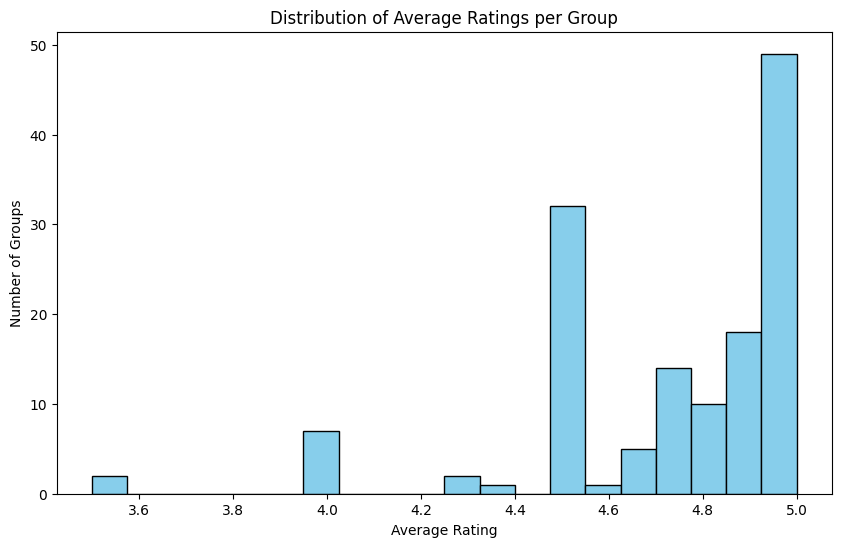

In [21]:
import matplotlib.pyplot as plt

# Create a histogram of average ratings per group
plt.figure(figsize=(10, 6))
plt.hist(group_avg_ratings_df['AverageRating'].dropna(), bins=20, color='skyblue', edgecolor='black')

# Add labels and title in English
plt.xlabel('Average Rating')
plt.ylabel('Number of Groups')
plt.title('Distribution of Average Ratings per Group')

# Show the histogram
plt.show()


In [22]:
import pandas as pd
from tqdm import tqdm
import plotly.express as px

# Assuming `individual_ratings_df` is already defined and contains "GroupID", "UserID", "WineID", and "Rating".

# Schritt 1: Definieren eines Schwellenwerts für Zufriedenheit
satisfaction_threshold = 4.0  # Alle Bewertungen >= 4.0 werden als zufriedenstellend betrachtet

# Schritt 2: Berechnung der Satisfaction Rate für jede Gruppe
satisfaction_rate_per_group = []

# Berechnung der Satisfaction Rate mit `groupby`
for group_id, group_df in individual_ratings_df.groupby('GroupID'):
    # Berechne die Anzahl der zufriedenen Bewertungen (Rating >= threshold)
    satisfied_count = group_df[group_df['Rating'] >= satisfaction_threshold].shape[0]
    
    # Gesamtzahl der Bewertungen für diese Gruppe
    total_count = group_df.shape[0]
    
    # Berechne die Satisfaction Rate, wenn Bewertungen vorhanden sind
    satisfaction_rate = satisfied_count / total_count if total_count > 0 else None
    
    # Speichern der Satisfaction Rate für die aktuelle Gruppe
    satisfaction_rate_per_group.append((group_id, satisfaction_rate))

# Schritt 3: Umwandeln der Liste in einen DataFrame
satisfaction_rate_df = pd.DataFrame(satisfaction_rate_per_group, columns=["GroupID", "SatisfactionRate"])

# Schritt 4: Histogramm erstellen, um die Verteilung der Satisfaction Rate pro Gruppe anzuzeigen
fig = px.histogram(satisfaction_rate_df, x='SatisfactionRate',
                   nbins=10,  # Anzahl der Bins im Histogramm (z.B. 10 für 0-1 in 0.1-Schritten)
                   labels={'SatisfactionRate': 'Satisfaction Rate'},
                   title='Distribution of Satisfaction Rate Across Groups')

# Interaktives Histogramm anzeigen
fig.show()



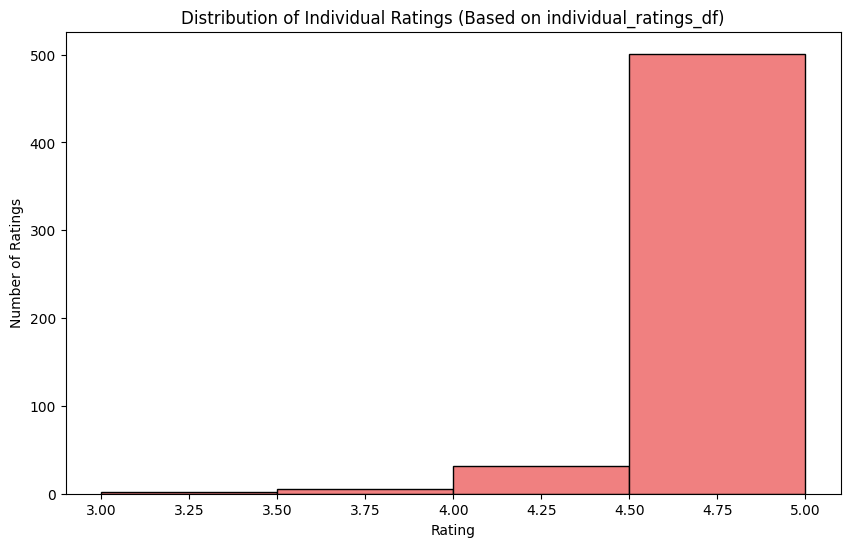

In [23]:
import matplotlib.pyplot as plt

# Stellen Sie sicher, dass `individual_ratings_df` der DataFrame mit den individuellen Bewertungen ist
# und die Spalte "Rating" enthält

# Größe der Grafik festlegen
plt.figure(figsize=(10, 6))

# Histogramm der Spalte `Rating` im DataFrame `individual_ratings_df` erstellen
plt.hist(individual_ratings_df['Rating'], bins=4, color='lightcoral', edgecolor='black')

# Labels und Titel hinzufügen
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Individual Ratings (Based on individual_ratings_df)')

# Histogramm anzeigen
plt.show()


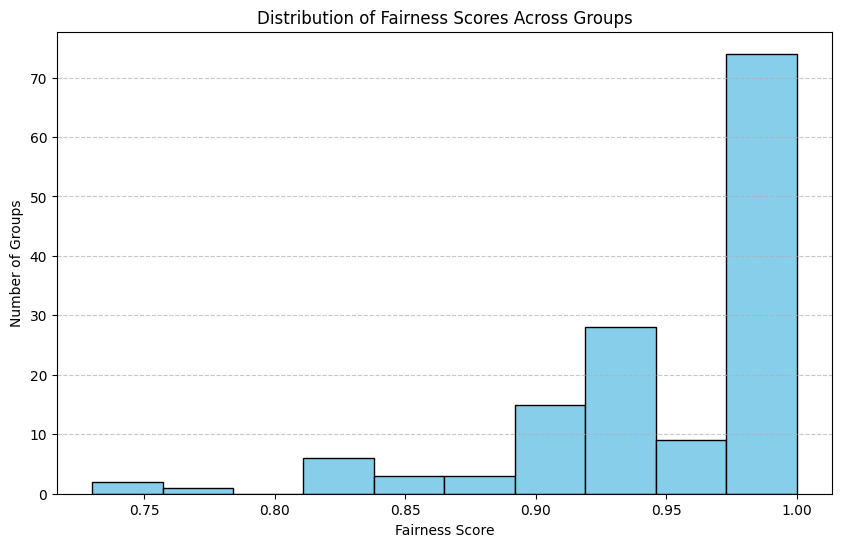

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Beispielannahme: `individual_ratings_df` enthält die Spalten "GroupID", "UserID", "WineID" und "Rating".

# Funktion zur Berechnung der Fairness basierend auf den Bewertungen einer Gruppe
def calculate_fairness(group_ratings_df):
    """
    Berechnet die Fairness basierend auf der Standardabweichung der Gruppenbewertungen.

    Parameter:
    - group_ratings_df: DataFrame mit den Spalten 'UserID', 'WineID' und 'Rating'.

    Rückgabe:
    - Fairness-Score (zwischen 0 und 1), wobei 1 perfekte Fairness bedeutet.
    """
    # Überprüfen, ob keine Bewertungen vorliegen oder alle Bewertungen identisch sind
    if group_ratings_df.empty or len(group_ratings_df['Rating'].unique()) == 1:
        return 1.0  # Perfekte Fairness

    # Berechnung der Standardabweichung der Bewertungen in der Gruppe
    std_dev = group_ratings_df['Rating'].std()

    # Fairness-Score berechnen: 1 - (std deviation) / (max rating - min rating)
    fairness = 1 - (std_dev / (5 - 1))  # max Rating = 5, min Rating = 1

    return round(fairness, 2)  # Fairness-Wert auf 2 Dezimalstellen runden

# Schritt 1: Berechnung der Fairness für jede Gruppe basierend auf `individual_ratings_df`
group_fairness_scores = []  # Speichert die Fairness-Werte für jede Gruppe

# Iteration über alle Gruppen-IDs in `individual_ratings_df` mit `groupby`
for group_id, group_df in individual_ratings_df.groupby('GroupID'):
    # Berechnung der Fairness für die aktuelle Gruppe
    fairness_score = calculate_fairness(group_df)

    # Speichern der Gruppen-ID und des Fairness-Scores
    group_fairness_scores.append({'GroupID': group_id, 'FairnessScore': fairness_score})

# Konvertieren der Ergebnisse in einen DataFrame zur besseren Visualisierung
fairness_df = pd.DataFrame(group_fairness_scores)

# Schritt 2: Visualisierung der Fairness Scores als Histogramm
plt.figure(figsize=(10, 6))  # Größe der Grafik festlegen
plt.hist(fairness_df['FairnessScore'].dropna(), bins=10, color='skyblue', edgecolor='black')  # Histogramm der Fairness-Werte
plt.xlabel('Fairness Score')  # X-Achsen-Beschriftung
plt.ylabel('Number of Groups')  # Y-Achsen-Beschriftung
plt.title('Distribution of Fairness Scores Across Groups')  # Titel des Diagramms
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Gitterlinie für bessere Lesbarkeit
plt.show()


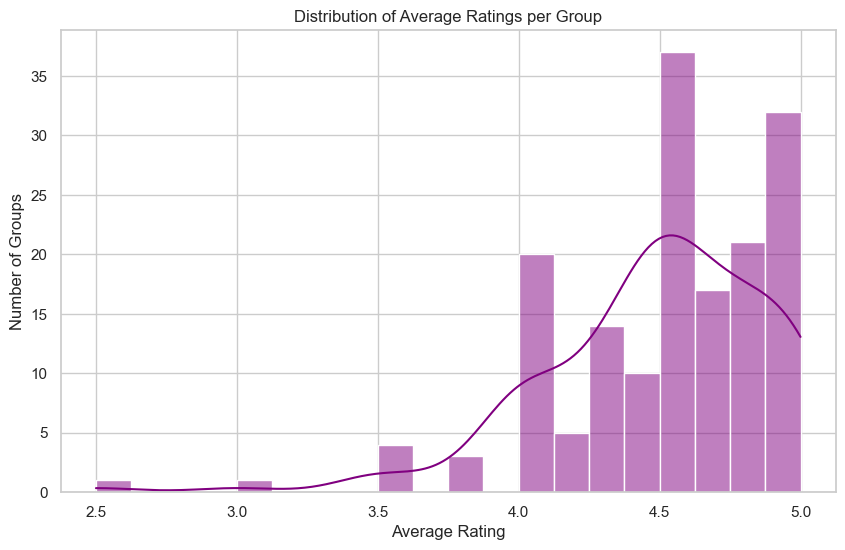

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the histogram
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(group_avg_ratings_df['AverageRating'].dropna(), bins=20, kde=True, color='purple')

# Add labels and title in English
plt.xlabel('Average Rating')
plt.ylabel('Number of Groups')
plt.title('Distribution of Average Ratings per Group')

# Show the histogram
plt.show()


In [77]:
def calculate_least_misery(group_id, group_data, ratings_data, wine_data, n=5):
    # Step 1: Get the top n recommended wines for the group
    recommended_wine_ids = recommend_for_group(group_id, group_data, ratings_data, wine_data, wine_id_only=True, n=n)

    # Convert recommended_wine_ids to a list (if it's a Series or another object)
    if not isinstance(recommended_wine_ids, list):
        recommended_wine_ids = recommended_wine_ids.tolist()

    # Step 2: Get ratings of the group members for these recommended wines
    group_ratings_df = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=recommended_wine_ids)

    # Step 3: Check if group_ratings_df is empty, which means no ratings for these wines by group members
    if group_ratings_df.empty:
        return pd.DataFrame(columns=['WineID', 'LeastMiseryScore'])

    # Step 4: Calculate Least Misery: the minimum rating for each recommended WineID within the group
    least_misery_df = group_ratings_df[group_ratings_df['WineID'].isin(recommended_wine_ids)].groupby('WineID')['Rating'].min().reset_index()
    least_misery_df.columns = ['WineID', 'LeastMiseryScore']

    return least_misery_df


In [78]:
# Iterate over all group IDs and calculate the Least Misery score for each group
all_group_least_misery = []  # Initialize an empty list to store results

for group_id in range(240):  # Assuming there are 240 groups (IDs 0 to 239)
    try:
        # Calculate least misery for the current group
        least_misery_df = calculate_least_misery(group_id, group_data, ratings_data, wine_data, n=5)
        
        # Check if the DataFrame is not empty before appending
        if not least_misery_df.empty:
            # Append group ID to the result for better tracking
            least_misery_df['GroupID'] = group_id
            all_group_least_misery.append(least_misery_df)
    except Exception as e:
        print(f"Error processing Group ID {group_id}: {e}")

# Ensure that there are DataFrames to concatenate
if all_group_least_misery:
    # Concatenate the results for all groups into a single DataFrame
    least_misery_results_df = pd.concat(all_group_least_misery, ignore_index=True)


Error processing Group ID 0: 'Rating'
Error processing Group ID 1: 'Rating'
Error processing Group ID 2: 'Rating'
Error processing Group ID 3: 'Rating'
Error processing Group ID 4: 'Rating'
Error processing Group ID 5: 'Rating'
Error processing Group ID 6: 'Rating'
Error processing Group ID 7: 'Rating'
Error processing Group ID 8: 'Rating'
Error processing Group ID 9: 'Rating'
Error processing Group ID 10: 'Rating'
Error processing Group ID 11: 'Rating'
Error processing Group ID 12: 'Rating'
Error processing Group ID 13: 'Rating'
Error processing Group ID 14: 'Rating'
Error processing Group ID 15: 'Rating'
Error processing Group ID 16: 'Rating'
Error processing Group ID 17: 'Rating'
Error processing Group ID 18: 'Rating'
Error processing Group ID 19: 'Rating'
Error processing Group ID 20: 'Rating'
Error processing Group ID 21: 'Rating'
Error processing Group ID 22: 'Rating'
Error processing Group ID 23: 'Rating'
Error processing Group ID 24: 'Rating'
Error processing Group ID 25: 'Rati

In [79]:
# import matplotlib.pyplot as plt

# # Create a histogram of Least Misery Scores
# plt.figure(figsize=(12, 6))
# plt.hist(least_misery_results_df['LeastMiseryScore'], bins=5, color='lightblue', edgecolor='black')
# plt.xlabel('Least Misery Score')
# plt.ylabel('Number of Recommended Wines')
# plt.title('Distribution of Least Misery Scores Across All Groups')
# plt.show()


NameError: name 'least_misery_results_df' is not defined

<Figure size 1200x600 with 0 Axes>

In [80]:
import pandas as pd
import numpy as np

def calculate_fairness(group_ratings_df):
    # Calculate standard deviation of ratings within the group for the recommended wines
    if group_ratings_df.empty or len(group_ratings_df['Rating'].unique()) == 1:
        # If there is only one unique rating or no ratings, fairness is 1 (perfect fairness)
        return 1.0

    std_dev = group_ratings_df['Rating'].std()  # Standard deviation of ratings

    # Calculate Fairness: 1 - (std deviation) / (max rating - min rating)
    fairness = 1 - (std_dev / (5 - 1))  # Using 5 as max and 1 as min rating

    return round(fairness, 2)  # Return the Fairness score rounded to 2 decimal places

# Beispiel: Berechnung der Fairness für alle Gruppen
group_fairness_scores = []  # Store the fairness scores for each group

for group_id in range(240):  # Assuming there are 240 groups
    try:
        # Get ratings for the group and recommended wines
        group_ratings_df = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=None)  # Get all ratings for the group

        # Calculate fairness for the current group
        fairness_score = calculate_fairness(group_ratings_df)
        
        # Store group ID and fairness score
        group_fairness_scores.append({'GroupID': group_id, 'FairnessScore': fairness_score})
    
    except Exception as e:
        print(f"Error processing Group ID {group_id}: {e}")

# Convert to DataFrame for better visualization
fairness_df = pd.DataFrame(group_fairness_scores)



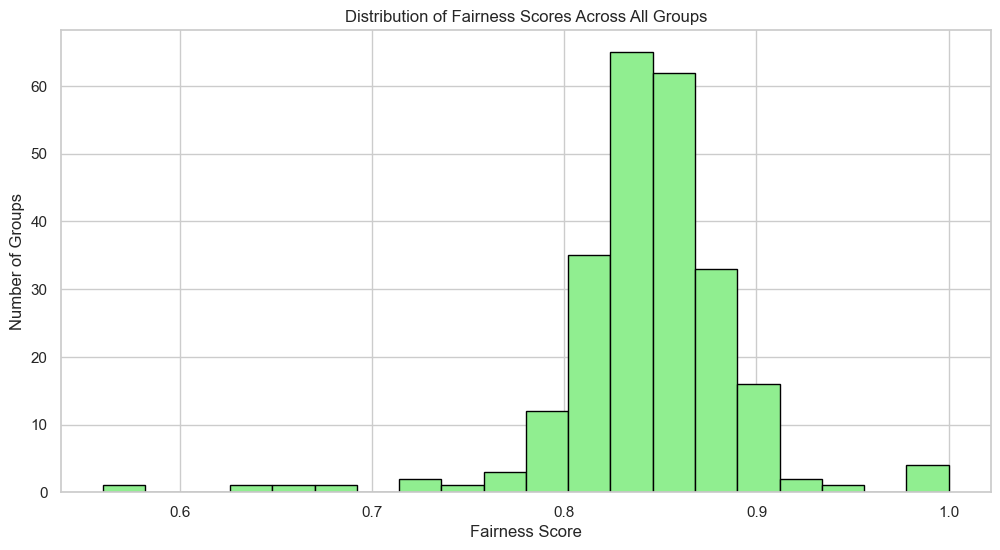

In [81]:
import matplotlib.pyplot as plt

# Create a histogram of fairness scores
plt.figure(figsize=(12, 6))
plt.hist(fairness_df['FairnessScore'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Fairness Score')
plt.ylabel('Number of Groups')
plt.title('Distribution of Fairness Scores Across All Groups')
plt.show()


C:\Users\antoi\AppData\Local\Temp\ipykernel_26536\2448386283.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




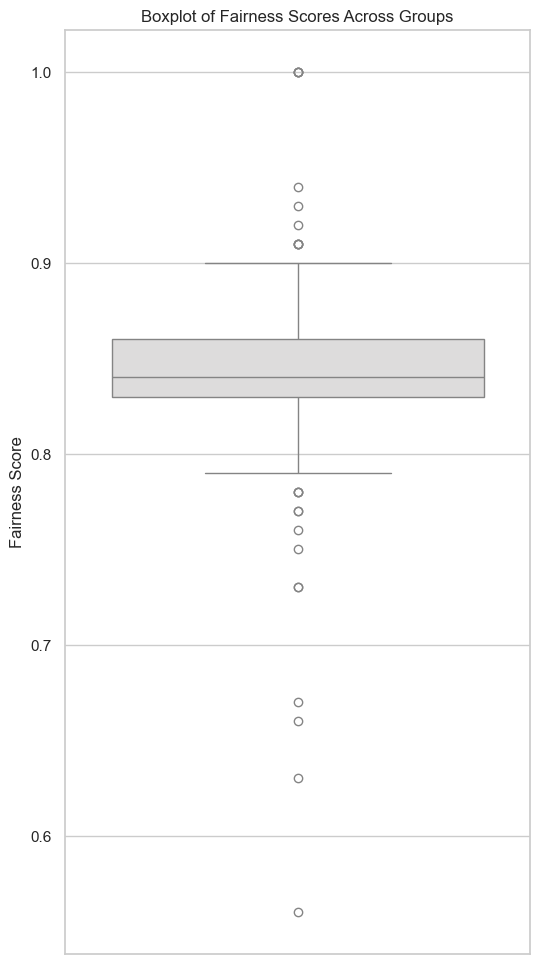

In [82]:
import seaborn as sns

# Create a boxplot to visualize the fairness scores across groups
plt.figure(figsize=(6, 12))
sns.boxplot(y='FairnessScore', data=fairness_df, palette='coolwarm')
plt.ylabel('Fairness Score')
plt.title('Boxplot of Fairness Scores Across Groups')
plt.show()


In [83]:
import pandas as pd

def calculate_satisfaction_rate(group_ratings_df, threshold=4):

    # Step 1: Check if the DataFrame is empty
    if group_ratings_df.empty:
        return 0.0

    # Step 2: Calculate satisfaction for each wine
    # Group by WineID and calculate the percentage of group members rating >= threshold
    satisfaction_df = group_ratings_df.groupby('WineID').apply(
        lambda x: (x['Rating'] >= threshold).mean()
    ).reset_index()
    
    # Step 3: Calculate Satisfaction Rate: Proportion of wines with a satisfaction rate >= 0.5
    satisfaction_df.columns = ['WineID', 'SatisfactionPercentage']
    satisfaction_rate = (satisfaction_df['SatisfactionPercentage'] >= 0.5).mean()

    return round(satisfaction_rate, 2)  # Return the satisfaction rate rounded to 2 decimal places

# Beispiel: Berechnung der Satisfaction Rate für alle Gruppen
group_satisfaction_scores = []  # Store the satisfaction rate for each group

for group_id in range(240):  # Assuming there are 240 groups
    try:
        # Get ratings for the group and recommended wines
        group_ratings_df = get_wines_rated_by_group(group_data, group_id, ratings_data, wine_id=None)  # Get all ratings for the group

        # Calculate satisfaction rate for the current group
        satisfaction_rate = calculate_satisfaction_rate(group_ratings_df)
        
        # Store group ID and satisfaction rate
        group_satisfaction_scores.append({'GroupID': group_id, 'SatisfactionRate': satisfaction_rate})
    
    except Exception as e:
        print(f"Error processing Group ID {group_id}: {e}")

# Convert to DataFrame for better visualization
satisfaction_df = pd.DataFrame(group_satisfaction_scores)


C:\Users\antoi\AppData\Local\Temp\ipykernel_26536\4128874332.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\antoi\AppData\Local\Temp\ipykernel_26536\4128874332.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\antoi\AppData\Local\Temp\ipykernel_26536\4128874332.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in 

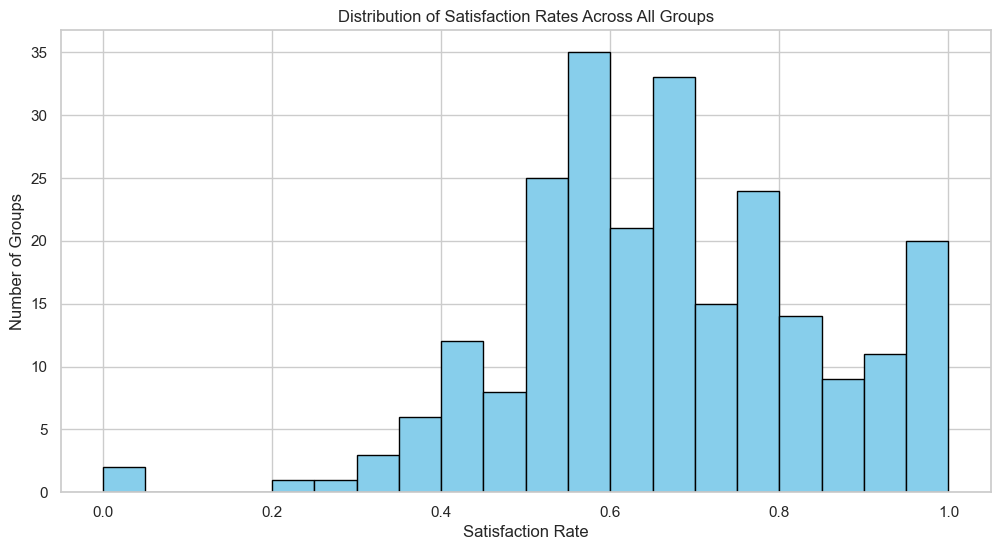

In [84]:
import matplotlib.pyplot as plt

# Create a histogram of satisfaction rates
plt.figure(figsize=(12, 6))
plt.hist(satisfaction_df['SatisfactionRate'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Satisfaction Rate')
plt.ylabel('Number of Groups')
plt.title('Distribution of Satisfaction Rates Across All Groups')
plt.show()


Average Fairness Score: 0.93
Average Satisfaction Rate: 0.99
Average Bewertung über alle Gruppen: 4.73


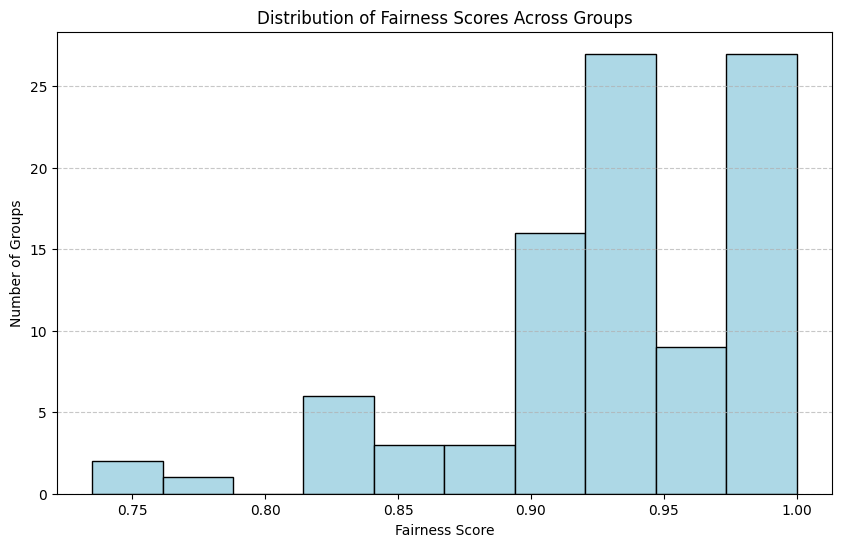

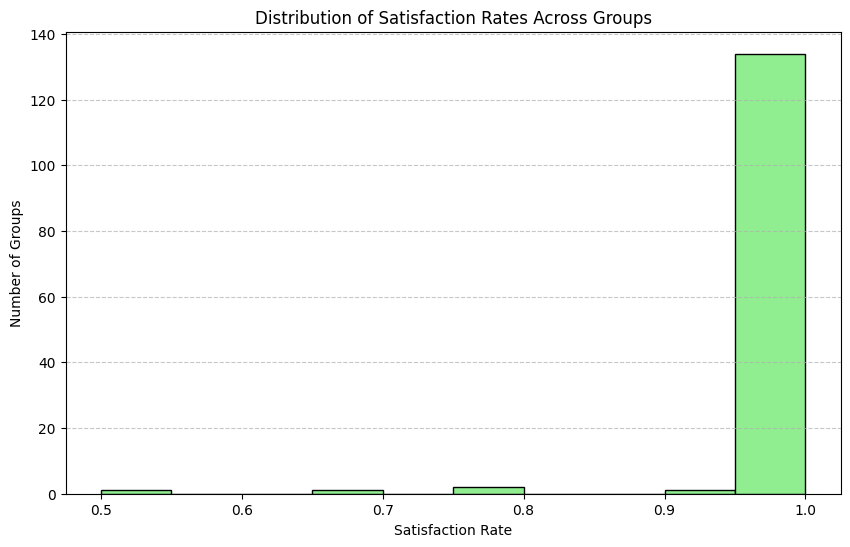

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Annahme: `group_avg_ratings_df` und `individual_ratings_df` sind bereits definiert.

# Schritt 1: Definiere den Zufriedenheitsschwellenwert
satisfaction_threshold = 4.0

# Schritt 2: Berechnung des Fairness Scores pro Gruppe
# Berechnen der Standardabweichung der Bewertungen für jede Gruppe
group_fairness_df = (
    individual_ratings_df.groupby('GroupID')['Rating']
    .std()  # Berechne die Standardabweichung pro Gruppe
    .reset_index()  # Zurücksetzen des Index
    .rename(columns={'Rating': 'StdDev'})  # Spalte umbenennen
)

# Berechnung des Fairness Scores: 1 - (Standardabweichung / (max rating - min rating))
group_fairness_df['FairnessScore'] = 1 - (group_fairness_df['StdDev'] / (5 - 1))

# Schritt 3: Berechnung der Satisfaction Rate pro Gruppe
# Berechnen des Anteils der zufriedenstellenden Bewertungen (z.B. >= 4.0) für jede Gruppe
group_satisfaction_df = (
    individual_ratings_df[individual_ratings_df['Rating'] >= satisfaction_threshold]  # Filter auf Zufriedenheitsbewertungen
    .groupby('GroupID').size()  # Anzahl zufriedener Bewertungen pro Gruppe
    .reset_index(name='SatisfiedCount')
)

# Berechnung der Gesamtanzahl der Bewertungen pro Gruppe
total_ratings_df = individual_ratings_df.groupby('GroupID').size().reset_index(name='TotalRatings')

# Merge der beiden DataFrames: Zufriedene Bewertungen + Gesamtanzahl
group_satisfaction_df = pd.merge(group_satisfaction_df, total_ratings_df, on='GroupID')

# Berechnung der Satisfaction Rate
group_satisfaction_df['SatisfactionRate'] = group_satisfaction_df['SatisfiedCount'] / group_satisfaction_df['TotalRatings']

# Schritt 4: Berechnung der durchschnittlichen Werte
overall_avg_rating = round(group_avg_ratings_df['AverageRating'].mean(), 2)
overall_fairness = round(group_fairness_df['FairnessScore'].mean(), 2)
overall_satisfaction = round(group_satisfaction_df['SatisfactionRate'].mean(), 2)

# Schritt 5: Ausgabe der durchschnittlichen Werte
print(f"Average Fairness Score: {overall_fairness}")
print(f"Average Satisfaction Rate: {overall_satisfaction}")
print(f"Average Bewertung über alle Gruppen: {overall_avg_rating}")

# Schritt 6: Visualisierung der Fairness Scores als Histogramm
plt.figure(figsize=(10, 6))
plt.hist(group_fairness_df['FairnessScore'].dropna(), bins=10, color='lightblue', edgecolor='black')
plt.xlabel('Fairness Score')
plt.ylabel('Number of Groups')
plt.title('Distribution of Fairness Scores Across Groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Schritt 7: Visualisierung der Satisfaction Rates als Histogramm
plt.figure(figsize=(10, 6))
plt.hist(group_satisfaction_df['SatisfactionRate'].dropna(), bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Satisfaction Rate')
plt.ylabel('Number of Groups')
plt.title('Distribution of Satisfaction Rates Across Groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
